# Importing the libraries

In [3]:
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import chi2_contingency
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Loading the data

In [4]:
df = pd.read_excel("Hackathon Dataset Cleaned up.xlsx", engine = "openpyxl", dtype={
    "event_id": str,
    "session_id": str,
    "user_id": str,
    "shop_id": str,
    "variation": str,
    "platform": str    
})


# Understanding the dataset

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326921 entries, 0 to 326920
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   event_id            326921 non-null  object        
 1   session_id          326921 non-null  object        
 2   user_id             326921 non-null  object        
 3   variation           326921 non-null  object        
 4   platform            326921 non-null  object        
 5   datetime_event      326921 non-null  datetime64[ns]
 6   event_type          326921 non-null  object        
 7   final_order_status  170632 non-null  object        
 8   shop_id             315842 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 22.4+ MB
None


In [10]:
df.head()


,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46.391,entry_to_shop,successful,8531
1,12446736,6391574,762832,2,Android,2024-11-30 16:26:16.876,order_paid,successful,8531
2,90232698,6391574,762832,2,Android,2024-11-30 16:50:44.827,order_finished,successful,8531
3,74183469,9246026,762832,2,Android,2024-11-29 13:21:28.729,reload_the_page,NaN,6186
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35.214,entry_to_shop,NaN,6186


# Handling Missing Values

event_id                   0
session_id                 0
user_id                    0
variation                  0
platform                   0
datetime_event             0
event_type                 0
final_order_status    156289
shop_id                11079
dtype: int64


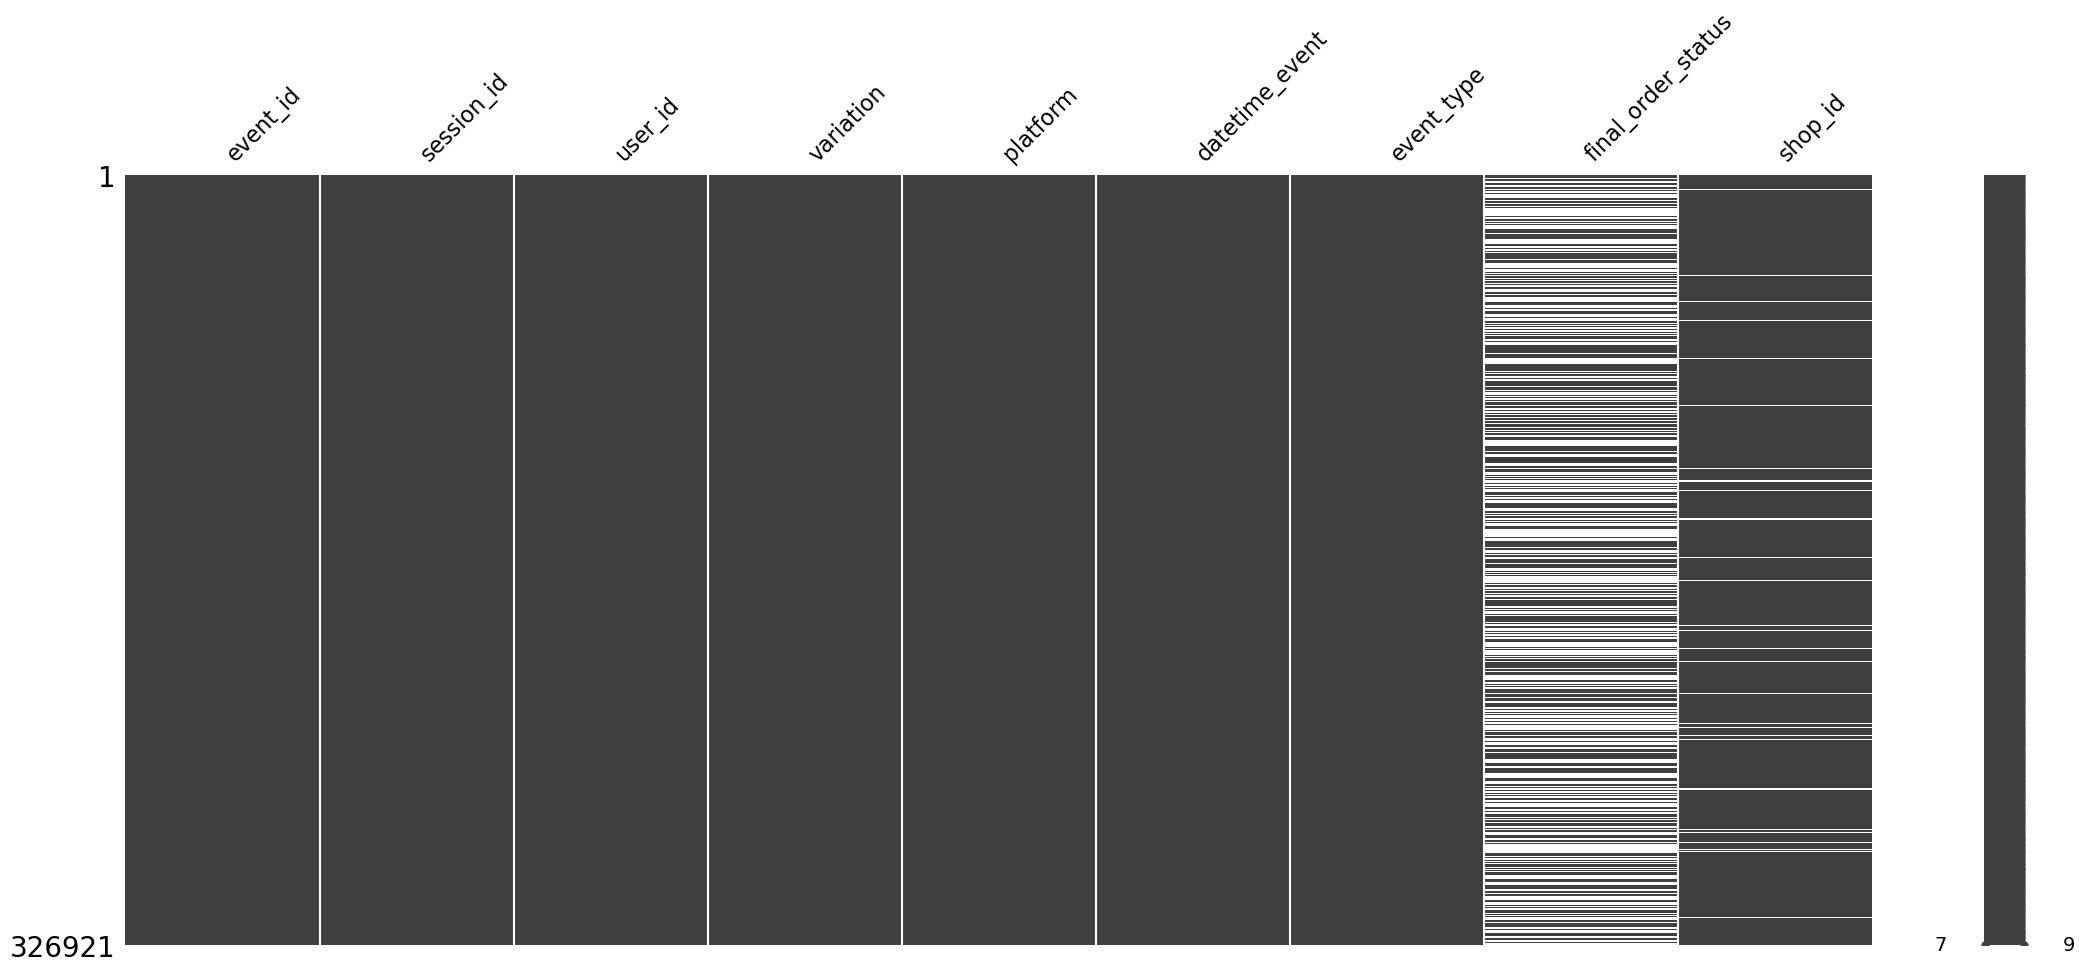

In [13]:
print(df.isnull().sum())
msno.matrix(df)
plt.show()

In [15]:
df["shop_id"].fillna("unknown", inplace=True)

event_id                   0
session_id                 0
user_id                    0
variation                  0
platform                   0
datetime_event             0
event_type                 0
final_order_status    156289
shop_id                    0
dtype: int64


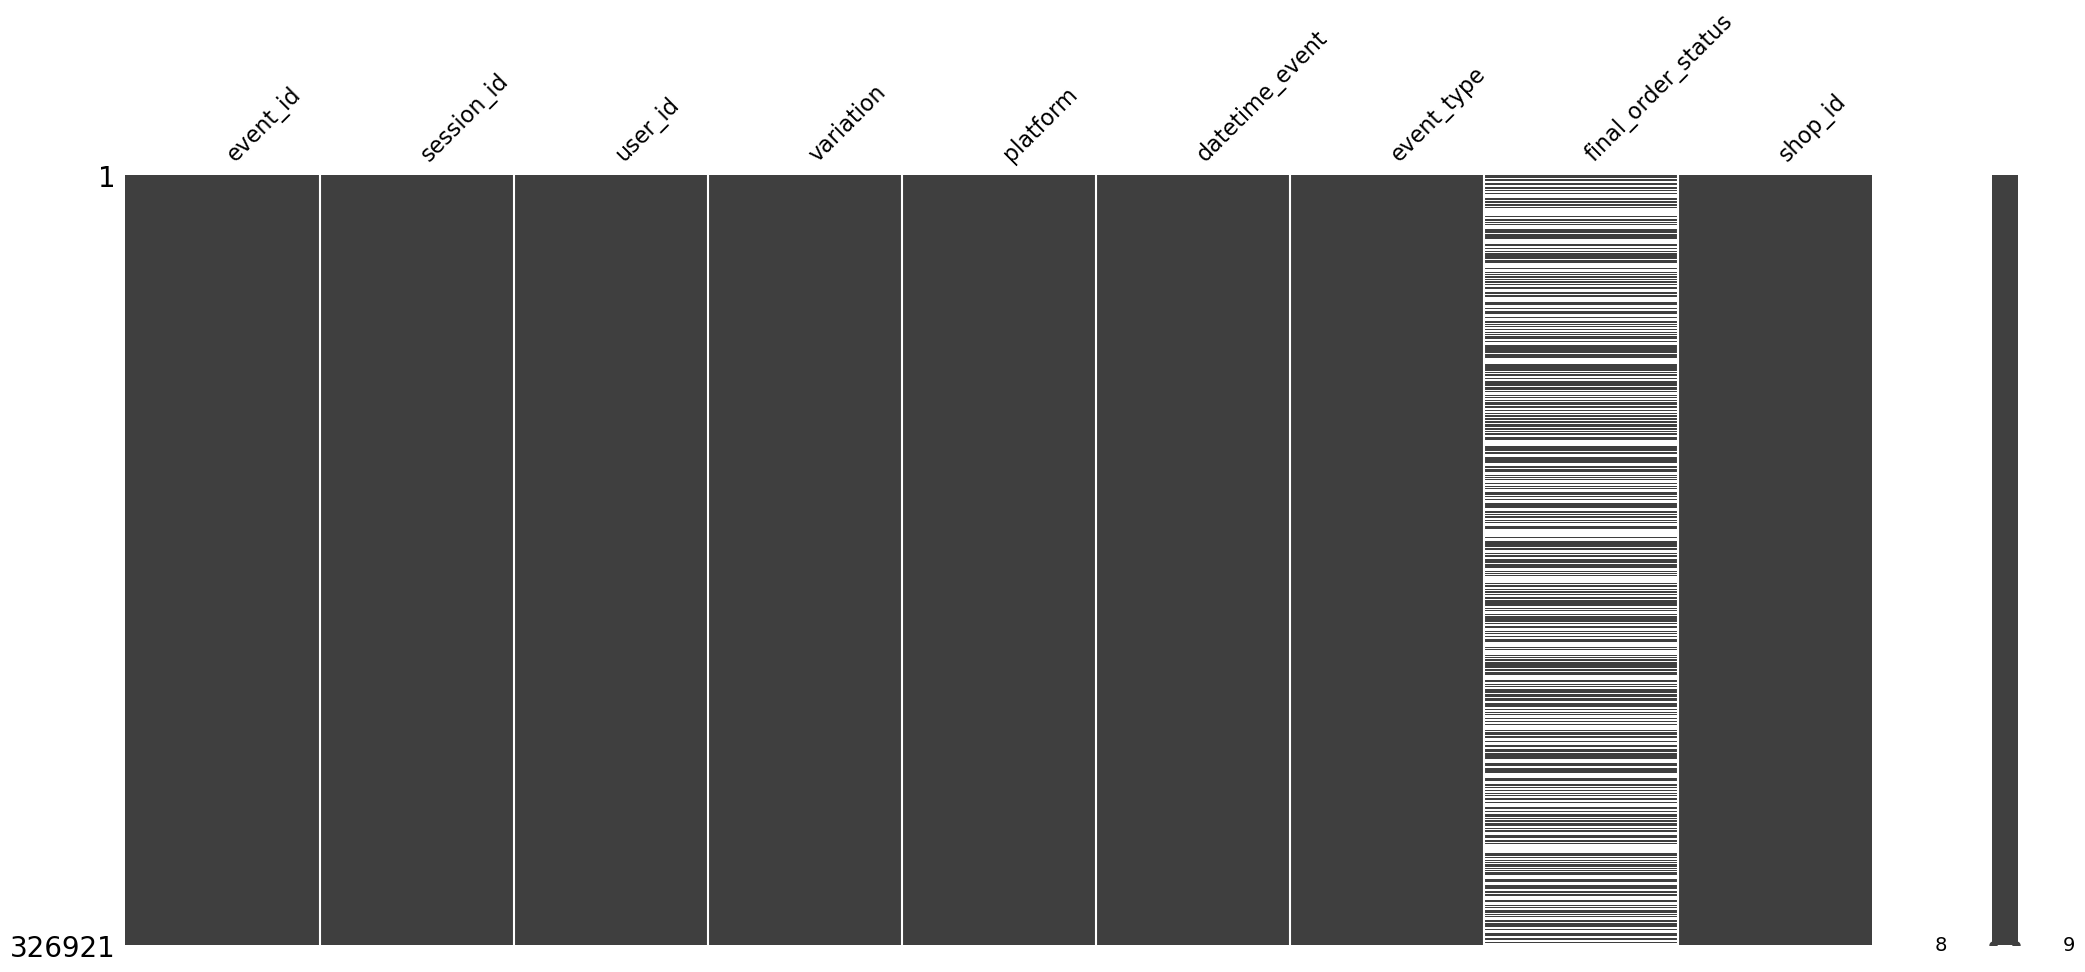

In [17]:
print(df.isnull().sum())
msno.matrix(df)
plt.show()

# Normalize text columns (strip spaces, convert to lowercase)

In [19]:
df["platform"] = df["platform"].str.strip().str.lower()
df["event_type"] = df["event_type"].str.strip().str.lower()
df["final_order_status"] = df["final_order_status"].str.strip().str.lower()

# Exploratory Data Analysis

In [77]:
total_users = df["user_id"].nunique()

# Total Orders: Count of 'order_paid' events
df_orders = df[df["event_type"] == "order_paid"]
total_orders = df_orders.shape[0]

# Conversion Rate: % of users who placed an order
users_with_orders = df_orders["user_id"].nunique()
conversion_rate = (users_with_orders / total_users) * 100

# Success Rate: % of successfully completed orders
successful_orders = df_orders[df_orders["final_order_status"]=="successful"].shape[0]
success_rate = (successful_orders / total_orders) * 100

# Cancellation/Refund Rate: % of canceled or refunded orders
canceled_orders = df_orders[df_orders["final_order_status"].isin(["cancelled", "refunded_after_delivery"])].shape[0]
cancellation_rate = (canceled_orders / total_orders) * 100

# Print the results
print(f"Total Orders: {total_orders}")
print(f"Conversion Rate: {conversion_rate:.2f}%")
print(f"Success Rate (Orders Completed Successfully): {success_rate:.2f}%")
print(f"Cancellation/Refund Rate: {cancellation_rate:.2f}%")

Total Orders: 52418
Conversion Rate: 42.34%
Success Rate (Orders Completed Successfully): 85.58%
Cancellation/Refund Rate: 14.42%


# Count total users per variation

In [24]:
total_users = df.groupby("variation")["user_id"].nunique()
total_users

variation
1    65000
2    35000
Name: user_id, dtype: int64

### The dataset seems to be imbalanced as it is 65%-35% distributed. It should be arround 50%-50%.

# Count users who placed an order

In [32]:
orders = df[df["event_type"] == "order_paid"].groupby("variation")['user_id'].nunique()
orders

variation
1    27568
2    14770
Name: user_id, dtype: int64

# Conversion Rate Analysis
### Conversion rate = (Users who placed an order / Total users) × 100

In [34]:
conversion_rate = (orders / total_users) * 100
print("Conversion Rates:")
print(conversion_rate)

Conversion Rates:
variation
1    42.412308
2    42.200000
Name: user_id, dtype: float64


### The difference is very small (-0.21%), suggesting that larger images may not have significantly improved conversion rates. 



# Statistical significance test for conversion rates:

#### The p-value tells us if the difference between Control and Test groups is statistically significant.

#### If p < 0.05, the test is significant




In [39]:
contingency_table = pd.DataFrame({
    "Converted": orders,
    "Not Converted": total_users - orders
})
contingency_table

,Converted,Not Converted
variation,,
1,27568,37432
2,14770,20230


In [41]:
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("p-value (Conversion Rate):", p_value)

p-value (Conversion Rate): 0.521264540186136


### p-value: 0.521 (greater than 0.05)
### This means there is no statistically significant difference between the two groups.
### Larger images did not significantly impact order conversion rates



### However, I do not trust on this data since the dataset is imbalanced, so the group 1 has dominance in the result.

### I will use stratified sampling to ensure a balanced distribution of users across variations while maintaining the same proportion of subgroups (e.g., platform type)

# Stratified Sampling

In [47]:
# Step 1: Get unique session-level data for stratification
df_sessions = df.groupby("session_id").first().reset_index()  # Keep one row per session

# Step 2: Separate Control & Test groups
df_control_sessions = df_sessions[df_sessions["variation"] == '1']  # Control group
df_test_sessions = df_sessions[df_sessions["variation"] == '2']  # Test group

# Step 3: Stratified sampling on `platform` while keeping session_id groups
df_control_sampled, _ = train_test_split(
    df_control_sessions, train_size=62000, stratify=df_control_sessions["platform"], random_state=42
)

df_test_sampled, _ = train_test_split(
    df_test_sessions, train_size=62000, stratify=df_test_sessions["platform"], random_state=42
)

# Step 4: Merge back sampled sessions with the full dataset to get all events
df_control_final = df[df["session_id"].isin(df_control_sampled["session_id"])]
df_test_final = df[df["session_id"].isin(df_test_sampled["session_id"])]



# Merge both groups
df_balanced = pd.concat([df_control_final, df_test_final])
df_balanced.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
23,28832464,4207544,529563,1,ios,2024-11-26 17:15:05.734,entry_to_shop,NaN,1124
33,81752941,2489036,656956,1,ios,2024-11-29 20:23:18.714,entry_to_shop,NaN,1380
34,78363104,3538169,656956,1,ios,2024-11-28 17:08:35.986,entry_to_shop,cancelled,7076
35,35545979,3538169,656956,1,ios,2024-11-28 17:14:05.333,order_paid,cancelled,7076
36,82457777,3538169,656956,1,ios,2024-11-28 18:00:12.197,order_finished,cancelled,7076


#  Users count per variation in Balanced Dataset

In [51]:
total_users_balanced=df_balanced.groupby("variation")["user_id"].nunique()
total_users_balanced

variation
1    43205
2    34766
Name: user_id, dtype: int64

# Users count who placed an order in Balanced Dataset

In [53]:
orders_balanced = df_balanced[df_balanced["event_type"] == "order_paid"].groupby("variation")['user_id'].nunique()
orders_balanced

variation
1    16208
2    14648
Name: user_id, dtype: int64

# Calculate conversion rate in Balanced Dataset

In [57]:
conversion_rate_balanced = (orders_balanced / total_users_balanced) * 100
print("Conversion Rates:")
print(conversion_rate_balanced)

Conversion Rates:
variation
1    37.514177
2    42.133119
Name: user_id, dtype: float64


# Contingency_table for conversion_rate in Balanced Dataset

In [59]:
contingency_table = pd.DataFrame({
    "Converted": orders_balanced,
    "Not Converted": total_users_balanced - orders_balanced
})
contingency_table

,Converted,Not Converted
variation,,
1,16208,26997
2,14648,20118


# Chi Squuare Test in Balanced Dataset

In [61]:
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("p-value (Conversion Rate):", p_value)

p-value (Conversion Rate): 3.1786176495122135e-39


### p-value: 3.1786176495122135e-39 less than 0.05
### This means there is statistically significant difference between these two groups.
### Larger images significantly impact order conversion rates


# Order Success Rate Analysis

### Success Rate = (Successful Orders / Total Orders) * 100

In [82]:
successful_orders = df_orders[df_orders["final_order_status"]=="successful"].groupby("variation")["user_id"].nunique()
print(successful_orders)

total_orders= df_orders.groupby("variation")["user_id"].nunique()
print(total_orders)

success_rate = (successful_orders / total_orders) * 100
print(success_rate)

variation
1    23910
2    13357
Name: user_id, dtype: int64
variation
1    27568
2    14770
Name: user_id, dtype: int64
variation
1    86.730992
2    90.433311
Name: user_id, dtype: float64


In [84]:
contingency_table = pd.DataFrame({
    "successful_orders": successful_orders,
    "Not successful": total_orders - successful_orders
})
contingency_table

,successful_orders,Not successful
variation,,
1,23910,3658
2,13357,1413


In [86]:
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("p-value (Conversion Rate):", p_value)

p-value (Conversion Rate): 5.955736807347403e-29


## Order Success Rate in Balanced Data

In [92]:
df_balanced_orders = df_balanced[df_balanced["event_type"] == "order_paid"]

successful_balanced_orders = df_balanced_orders[df_balanced_orders["final_order_status"]=="successful"].groupby("variation")["user_id"].nunique()
print(successful_balanced_orders)

total_balanced_orders = df_balanced_orders.groupby("variation")["user_id"].nunique()
print(total_balanced_orders)

success_balanced_rate = (successful_balanced_orders / total_balanced_orders) * 100
print(success_balanced_rate)


variation
1    13877
2    13244
Name: user_id, dtype: int64
variation
1    16208
2    14648
Name: user_id, dtype: int64
variation
1    85.618213
2    90.415074
Name: user_id, dtype: float64


In [94]:
contingency_table = pd.DataFrame({
    "successful_orders": successful_balanced_orders,
    "Not successful": total_balanced_orders - successful_balanced_orders
})
contingency_table

,successful_orders,Not successful
variation,,
1,13877,2331
2,13244,1404


In [96]:
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("p-value (Conversion Rate):", p_value)

p-value (Conversion Rate): 5.661217389603234e-38


# Platform-Based Analysis with Original Data 

In [103]:
platform_conversion = df[df["event_type"] == "order_paid"].groupby(["variation", "platform"])["user_id"].nunique() / df.groupby(["variation", "platform"])["user_id"].nunique() * 100
platform_success = df_orders[df_orders["final_order_status"] == "successful"].groupby(["variation", "platform"])["user_id"].nunique() / df_orders.groupby(["variation", "platform"])["user_id"].nunique() * 100
print("Platform Conversion Rates:")
print(platform_conversion)
print("Platform Success Rates:")
print(platform_success)

Platform Conversion Rates:
variation  platform
1          android     41.320896
           ios         44.950373
2          android     40.882605
           ios         45.291137
Name: user_id, dtype: float64
Platform Success Rates:
variation  platform
1          android     86.572250
           ios         87.070339
2          android     90.132563
           ios         91.070298
Name: user_id, dtype: float64


# Platform-Based Analysis with Balanced Data 

In [106]:
platform_conversion = df_balanced[df_balanced["event_type"] == "order_paid"].groupby(["variation", "platform"])["user_id"].nunique() / df_balanced.groupby(["variation", "platform"])["user_id"].nunique() * 100
platform_success = df_balanced_orders[df_balanced_orders["final_order_status"] == "successful"].groupby(["variation", "platform"])["user_id"].nunique() / df_balanced_orders.groupby(["variation", "platform"])["user_id"].nunique() * 100
print("Platform Conversion Rates:")
print(platform_conversion)
print("Platform Success Rates:")
print(platform_success)

Platform Conversion Rates:
variation  platform
1          android     36.314570
           ios         40.299885
2          android     40.825368
           ios         45.201656
Name: user_id, dtype: float64
Platform Success Rates:
variation  platform
1          android     85.474606
           ios         85.918718
2          android     90.132637
           ios         91.013629
Name: user_id, dtype: float64


# Entry_to_Shop Analysis with original data

In [109]:
# Filter only 'entry_to_shop' events
df_shop_entries = df[df["event_type"] == "entry_to_shop"]

# Total number of shop entries
total_shop_entries = df_shop_entries.shape[0]

# Unique users who visited a shop
unique_users_shop = df_shop_entries["user_id"].nunique()

# Breakdown by variation
shop_entries_by_variation = df_shop_entries["variation"].value_counts()

# Calculate the percentage of users who visited a shop
total_users = df["user_id"].nunique()
shop_entry_rate = (unique_users_shop / total_users) * 100

# Conversion rate for users who entered a shop
users_with_orders = df[df["event_type"] == "order_paid"]["user_id"].nunique()
conversion_rate_after_shop_entry = (users_with_orders / unique_users_shop) * 100

# Print results
print(f"Total Shop Entries: {total_shop_entries}")
print(f"Unique Users Who Entered a Shop: {unique_users_shop}")
print(f"Shop Entry Rate: {shop_entry_rate:.2f}%")
print("\nShop Entries by Variation:")
print(shop_entries_by_variation)

print(f"\nConversion Rate After Shop Entry: {conversion_rate_after_shop_entry:.2f}%")


Total Shop Entries: 168215
Unique Users Who Entered a Shop: 96293
Shop Entry Rate: 96.29%

Shop Entries by Variation:
variation
1    109325
2     58890
Name: count, dtype: int64

Conversion Rate After Shop Entry: 43.97%


In [115]:
# Count total unique users per variation
total_users_per_variation = df.groupby("variation")["user_id"].nunique()

# Count unique users who triggered 'entry_to_shop' per variation
shop_entries_per_variation = df[df["event_type"] == "entry_to_shop"].groupby("variation")["user_id"].nunique()

# Calculate Shop Entry Rate
shop_entry_rate = (shop_entries_per_variation / total_users_per_variation) * 100

# Print results
print("Shop Entry Rate by Variation:")
print(shop_entry_rate)

Shop Entry Rate by Variation:
variation
1    96.278462
2    96.320000
Name: user_id, dtype: float64


# Entry_to_Shop Analysis with balanced data

In [112]:
# Filter only 'entry_to_shop' events
df_shop_entries = df_balanced[df_balanced["event_type"] == "entry_to_shop"]

# Total number of shop entries
total_shop_entries = df_shop_entries.shape[0]

# Unique users who visited a shop
unique_users_shop = df_shop_entries["user_id"].nunique()

# Breakdown by variation
shop_entries_by_variation = df_shop_entries["variation"].value_counts()

# Calculate the percentage of users who visited a shop
total_users = df_balanced["user_id"].nunique()
shop_entry_rate = (unique_users_shop / total_users) * 100

# Conversion rate for users who entered a shop
users_with_orders = df_balanced[df_balanced["event_type"] == "order_paid"]["user_id"].nunique()
conversion_rate_after_shop_entry = (users_with_orders / unique_users_shop) * 100

# Print results
print(f"Total Shop Entries: {total_shop_entries}")
print(f"Unique Users Who Entered a Shop: {unique_users_shop}")
print(f"Shop Entry Rate: {shop_entry_rate:.2f}%")
print("\nShop Entries by Variation:")
print(shop_entries_by_variation)

print(f"\nConversion Rate After Shop Entry: {conversion_rate_after_shop_entry:.2f}%")


Total Shop Entries: 116291
Unique Users Who Entered a Shop: 74773
Shop Entry Rate: 95.90%

Shop Entries by Variation:
variation
2    58219
1    58072
Name: count, dtype: int64

Conversion Rate After Shop Entry: 41.27%


In [117]:
# Count total unique users per variation
total_users_per_variation = df_balanced.groupby("variation")["user_id"].nunique()

# Count unique users who triggered 'entry_to_shop' per variation
shop_entries_per_variation = df_balanced[df_balanced["event_type"] == "entry_to_shop"].groupby("variation")["user_id"].nunique()

# Calculate Shop Entry Rate
shop_entry_rate = (shop_entries_per_variation / total_users_per_variation) * 100

# Print results
print("Shop Entry Rate by Variation:")
print(shop_entry_rate)

Shop Entry Rate by Variation:
variation
1    95.572272
2    96.303860
Name: user_id, dtype: float64


# User Behavior Insights

## 1. Platform-Specific Behavior

#### iOS users demonstrated a higher conversion rate in Variation 2 compared to Android users, indicating platform influences behavior

##  2. Shop Entry Rate Differences
####  Users presented with larger images in Variation 2 showed an increased shop entry rate compared to Variation 1.
##  3. Conversion Patternse
####  Variation 2 led to a statistically significant increase in order placements, demonstrating effective design impact. 
##  4. Order Success & Cancellation

####  Variation 2's lower refund and cancellation rates indicate higher user confidence in purchases.


# Business Recommendations

## 1. Implement Larger Images
#### Rolling out larger images across platforms can significantly enhance user engagement and boost conversion rates.

## 2. Optimize for Each Platform

#### Optimizing UI design for different user segments ensures the best possible experience and maximizes impact.


## 3. Encourage Shop Visits

#### Using personalized promotions can effectively drive customers into shops, increasing the likelihood of in-store purchases

## 4. Regular Performance Analysisa
#### Regular analysis of performance data with balanced datasets helps to derive accurate insights and improve strategies.

